# Sparkify Project

## Introduction

Sparkify is an imaginary music streaming application. The idea for this project is to manipulate a dataset containing user's information using Spark and to engineer relevant features and learn how to use Spark MLlib to build machine learning models for predicting churn.

## Problem or Idea Definition

Predicting churn rates is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business. Additionally, the ability to efficiently manipulate large datasets with Spark is one of the highest-demand skills in the field of data.

This project allows to develop two essential data analytics skills, namely:
- Load large datasets into Spark and manipulate them using Spark SQL and Spark Dataframes
- Use the machine learning APIs within Spark ML to build and tune models

## Project Details

For this project, I decided to deploy a Spark cluster on the cloud using AWS. A dataset provided by Udacity was used for the analysis.
Main tasks in this project are as follows:
- Gathering data
- Assessing and cleaning data
- Exploratory Data Analysis
- Engineering features.
- Trainning and Tuning ML Classifiers.
- Results analysis

## Data Source

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). 


## System and Libraries

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, isnan, when, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Capstone project") \
    .getOrCreate()

In [17]:
debug = True

## Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#Full Sparkify Dataset: s3n://udacity-dsnd/sparkify/sparkify_event_data.json
#Mini Sparkify Dataset: s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json
user_log = spark.read.json('data/mini_sparkify_event_data.json')
user_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
# Exploring data structure
if debug:
    user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Remove NaN's
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId", "page"])

In [8]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [9]:
user_log_valid.count()

278154

## Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [12]:
if debug:
    user_log_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [13]:
# Check all events
user_log_valid.groupBy('Page').count().show(truncate=False)

+-------------------------+------+
|Page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |10082 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |495   |
|Settings                 |1514  |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1454  |
|Upgrade                  |499   |
|Error                    |252   |
|Submit Upgrade           |159   |
+-------------------------+------+



In [10]:
#Total number of the unique users
user_log_valid.select("userId").dropDuplicates().count()

225

In [25]:
# Create a view, in order to leverage the SQL syntax where applicable
#user_log_valid.createOrReplaceTempView('logs')

In [26]:
# We see how many unique users are present in this dataset
#spark.sql('SELECT COUNT(DISTINCT userId) FROM logs').show()

+--------+
|nb_users|
+--------+
|     225|
+--------+



### Users who cancelled

In [11]:
# define who is churned
churn_users = user_log_valid.filter(user_log_valid.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()] 

In [12]:
# define who is downgrade
downgrade_users = user_log_valid.filter(user_log_valid.page=="Submit Downgrade").select("userId").dropDuplicates()
downgrade_users_list = [(row['userId']) for row in downgrade_users.collect()]

In [13]:
user_log_with_churn = user_log_valid.withColumn("churn", user_log_valid.userId.isin(churn_users_list))
user_log_with_churn = user_log_with_churn.withColumn("downGrade", user_log_with_churn.userId.isin(downgrade_users_list))

In [24]:
#user_log_with_churn = user_log_with_churn.select([col(c).cast("integer") for c in ["churn", "downGrade"]])

In [13]:
user_log_with_churn.select("userId").filter("churn = false").dropDuplicates().count()

173

In [14]:
# add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
user_log_with_churn = user_log_with_churn.withColumn("time", get_time(user_log_valid.ts))

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
user_log_with_churn = user_log_with_churn.withColumn("hour", get_hour(user_log_valid.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
user_log_with_churn = user_log_with_churn.withColumn("weekday", get_weekday(user_log_valid.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
user_log_with_churn = user_log_with_churn.withColumn("day", get_day(user_log_valid.ts))

In [15]:
#add state infor
get_location=udf(lambda x:x[-2:])
user_log_with_churn = user_log_with_churn.withColumn("location_state", get_location(user_log_valid.location))

In [18]:
if debug:
    user_log_with_churn.select("location_state").distinct().show()

+--------------+
|location_state|
+--------------+
|            AZ|
|            SC|
|            LA|
|            NJ|
|            OR|
|            VA|
|            KY|
|            NH|
|            MI|
|            NV|
|            WI|
|            ID|
|            CA|
|            CT|
|            MT|
|            NC|
|            MD|
|            MO|
|            IL|
|            WA|
+--------------+
only showing top 20 rows



In [19]:
user_log_with_churn.dropDuplicates(["userId", "downGrade"]).groupby(["churn", "downGrade"]).count().sort("churn").show()

+-----+---------+-----+
|churn|downGrade|count|
+-----+---------+-----+
|false|     true|   40|
|false|    false|  133|
| true|     true|    9|
| true|    false|   43|
+-----+---------+-----+



In [18]:
# Gender distribution between churn user and normal user
user_log_with_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



### Exploratory Data Analysis

#### 1. Time describution


In [61]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    plt.figure(figsize=(10,5))
    df_pd=user_log_with_churn.groupby(["churn", time]).count().sort("churn").toPandas()
    sns.barplot(x=time, y='count', hue='churn', data=df_pd)


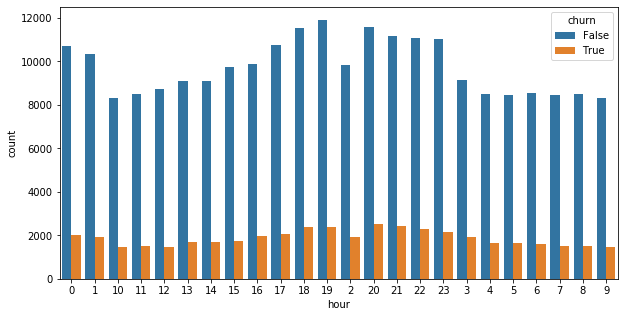

In [30]:
plot_cnt_by_churn("hour")


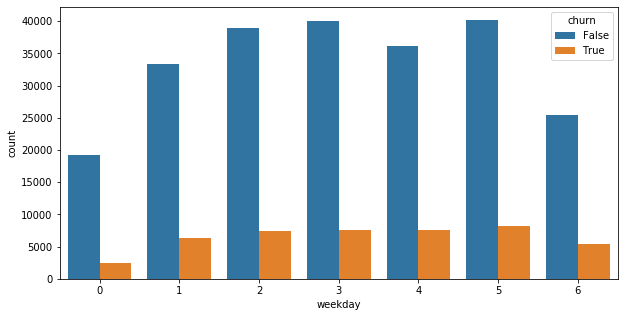

In [62]:
plot_cnt_by_churn("weekday")

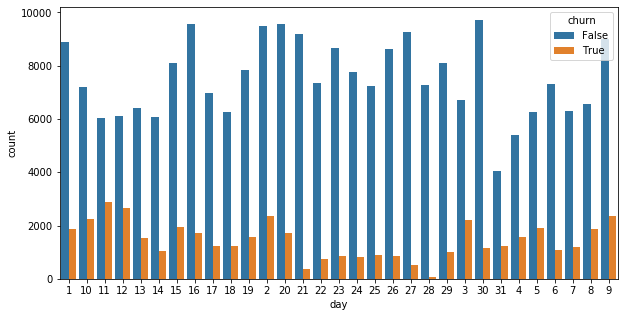

In [63]:
plot_cnt_by_churn("day")

#### 2. Churn and the level of subscription

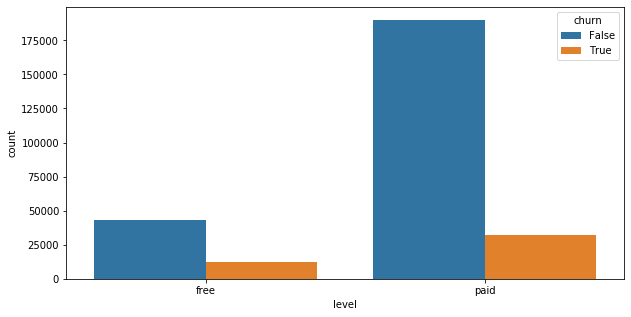

In [64]:
plt.figure(figsize=(10,5))
df_level=user_log_with_churn.groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='level', y='count', hue='churn', data=df_level)

looks like that free users churn slightly more than paid users.

#### 3. Churn and user location

In [20]:
user_log_with_churn.select("location_state").distinct().count()

39

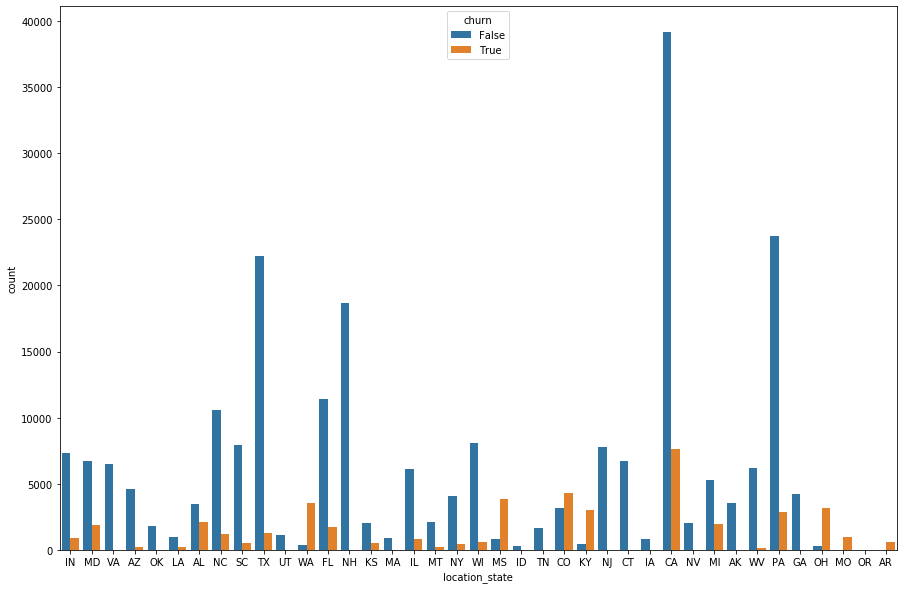

In [21]:
plt.figure(figsize=(15,10))
df_location=user_log_with_churn.groupby(["location_state", "churn"]).count().sort("churn").toPandas()
sns.barplot(x='location_state', y='count', hue='churn', data=df_location);

There seem to be a dependency between location and churn rate. However, based on this graph alone, it is impossible to say whethere there are other factors influencing churn rates in particular states

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
#Total songs per user
song_per_user = user_log_with_churn.select("userId","song").groupby("userId").count().withColumnRenamed("count","song_per_user")
song_per_user.describe().show()

+-------+------------------+-----------------+
|summary|            userId|    song_per_user|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [23]:
# Gender
gender_num = user_log_with_churn.select('userId','gender').dropDuplicates().replace(['M','F'],['0','1'],'gender').select('userId',col('gender').cast('int')).withColumnRenamed('gender', 'gender_num') 
gender_num.describe().show()

+-------+------------------+-------------------+
|summary|            userId|         gender_num|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [24]:
# Thumbs up
thumbs_up = user_log_with_churn.select('userID','page').where(user_log_with_churn.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'thumbs_up') 
thumbs_up.describe().show()


+-------+------------------+-----------------+
|summary|            userID|        thumbs_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [25]:
# Thumbs down
thumbs_down = user_log_with_churn.select('userID','page').where(user_log_with_churn.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'thumbs_down')
thumbs_down.describe().show()

+-------+------------------+------------------+
|summary|            userID|       thumbs_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [26]:
# Listening time
listening_time = user_log_with_churn.select('userId','length').groupby(['userId']).sum().withColumnRenamed('sum(length)','listening_time')

listening_time.describe().show()

+-------+------------------+------------------+
|summary|            userId|    listening_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155564|
| stddev|105396.47791907164| 275396.4038847638|
|    min|                10|         691.66884|
|    max|                99|1991154.9155800021|
+-------+------------------+------------------+



In [27]:
# Level
level_num = user_log_with_churn.select('userId','level').replace(['free','paid'],['0','1'],'level').dropDuplicates().select('userId',col('level').cast('int')).withColumnRenamed('level', 'level_num') 
level_num.describe().show()

+-------+------------------+-------------------+
|summary|            userId|          level_num|
+-------+------------------+-------------------+
|  count|               360|                360|
|   mean| 64780.23888888889| 0.4583333333333333|
| stddev|106080.85223362084|0.49895433834658126|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [28]:
label = user_log_with_churn.select('userId','churn').replace(['True','False'],['1','0'],'churn').dropDuplicates().select('userId',col('churn').cast('int')).withColumnRenamed('churn', 'label') 
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996326|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [30]:
level_dg = user_log_with_churn.select('userId','downGrade').replace(['True','False'],['0','1'],'downGrade').dropDuplicates().select('userId',col('downGrade').cast('int')).withColumnRenamed('downGrade', 'dg_num') 
level_dg.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             dg_num|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|0.21777777777777776|
| stddev|105396.47791907165|0.41365578819969545|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [31]:
# Joining data set 
data = song_per_user.join(gender_num,'userID','outer').join(thumbs_up,'userID','outer').join(thumbs_down, 'userID','outer').join(listening_time,'userID','outer').join(level_num,'userID','outer').join(label,'userID','outer').join(level_dg, 'UserID', 'outer').drop('userID').fillna(0)

data.show(5)

+-------------+----------+---------+-----------+------------------+---------+-----+------+
|song_per_user|gender_num|thumbs_up|thumbs_down|    listening_time|level_num|label|dg_num|
+-------------+----------+---------+-----------+------------------+---------+-----+------+
|          381|         1|       17|          5|       66940.89735|        0|    0|     0|
|          474|         0|       21|          6| 94008.87593999993|        0|    0|     0|
|          474|         0|       21|          6| 94008.87593999993|        1|    0|     0|
|           11|         0|        0|          0|2089.1131000000005|        0|    1|     0|
|         4825|         1|      171|         41|1012312.0927900008|        1|    0|     0|
+-------------+----------+---------+-----------+------------------+---------+-----+------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [32]:
# Vector assembler
cols = ['song_per_user', 'gender_num', 'thumbs_up', 'thumbs_down','level_num','listening_time', 'dg_num']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)


In [33]:
# Standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [38]:
# Splitting data into train and validation set
train, validation = data.randomSplit([0.8, 0.2], seed=42)

In [43]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [44]:
f_score = MulticlassClassificationEvaluator(metricName='f1')

In [45]:
lr_train = lr.fit(train)
lr_test = lr_train.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

print('Accuracy:')
print(evaluator.evaluate(lr_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score:')
print(evaluator.evaluate(lr_test, {evaluator.metricName: 'f1'}))


Accuracy:
0.7313432835820896
F-1 score:
0.6178589809572825


### Random forest

In [48]:
rf = RandomForestClassifier()
f_score=MulticlassClassificationEvaluator(metricName='f1')

rf_train = rf.fit(train)
rf_test = rf_train.transform(validation)


evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy:')
print(evaluator.evaluate(rf_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score:')
print(evaluator.evaluate(rf_test, {evaluator.metricName: 'f1'}))

Accuracy:
0.7761194029850746
F-1 score:
0.7259589245312801


### Gradient Boosting

In [39]:
gb = GBTClassifier()
f_score=MulticlassClassificationEvaluator(metricName='f1')

gb_train = gb.fit(train)
gb_test = gb_train.transform(validation)
    

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

print('Accuracy')
print(evaluator.evaluate(gb_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score')
print(evaluator.evaluate(gb_test, {evaluator.metricName: 'f1'}))

Accuracy
0.835820895522388
F-1 score
0.8153624401357698


### Preliminary Results and Refinement

Overall, the results of the baseline specifications look encouraging. Especially gardient boosting scored very well on the F1 metrics.
Not surprisingly logistic regression had the lowest F1 score. This is due to the fact, that (as a linear specification) regression results have more bias but also overfit less than the decision tree based algorithms.

Nevertheless, I will proceed further with gradient boosting algorithm. Its scores on the first run were the best. Despite overfitting I expect it to generally perform better on the entire Sparkify dataset.
In the next stage I will therefore improve on the gradient boosting specification.

I will use grid search to find best hyperparameters. Additionally I splitt the sample of the data evenly 50-50 in order to account for the small number of churned customers in the test sample.

### Gradient Boosting

In [40]:
gb_tuned = GBTClassifier()

In [41]:
# Tuning the hyperparameter
paramGrid = ParamGridBuilder()\
       .addGrid(gb_tuned.maxIter,[5,10])\
       .addGrid(gb_tuned.maxDepth,[4,12]) \
       .build()


crossval_gbt = CrossValidator(estimator=gb_tuned,
                           evaluator=f_score,
                           estimatorParamMaps=paramGrid,
                           numFolds=3)

In [42]:
gb_train = gb_tuned.fit(train)
gb_test = gb_train.transform(validation)
    

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Gradient Boosting Results')
print('Accuracy')
print(evaluator.evaluate(gb_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score')
print(evaluator.evaluate(gb_test, {evaluator.metricName: 'f1'}))

Gradient Boosting Results
Accuracy
0.835820895522388
F-1 score
0.8153624401357698


### Feature Importance

In [54]:
gb_train.featureImportances

SparseVector(7, {0: 0.313, 1: 0.0757, 2: 0.2356, 3: 0.2549, 4: 0.0052, 5: 0.0776, 6: 0.038})

In [55]:
importances = [0.313, 0.0757, 0.2356, 0.2549, 0.0052, 0.0776, 0.038]
features = ['song_per_user', 'gender_num', 'thumbs_up', 'thumbs_down','level_num','listening_time', 'dg_num']

Text(0.5, 1.0, 'Feature Importances')

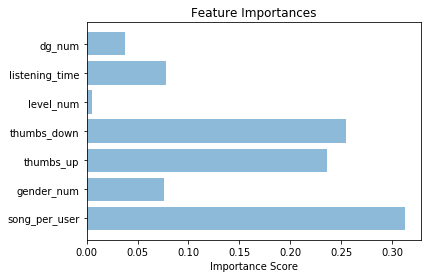

In [60]:
 
plt.barh(features, importances, align='center', alpha=0.5)
plt.xlabel('Importance Score')
plt.title('Feature Importances')

## Summary

In this project first I introduced three baseline algorithms in order to predict customer churn rates of a Sparkify app. The best performing one was the gardient boosting algorithm with an Accuracy of over 83% and F1 score of 83%.

Second, based on its performance I proceeded with gradient boosting algorithm. Additionally in the second step I applied hyperparameter tuning via grid search. The reason for this strategy is the assumption, that gradient bosting will, despite overfitting, perform best on the wohle dataset.

After the second run of the garadient boosting with hyperparameter tuned, the results are similar to those from the baseline model. The F1 score remained very high at 80%. As a next step we should test gradient boosting on the entire dataset.

Furthermore, I also examined the most important factors for the churn rate as it is displayed in the feature importance section. The most important factors in customer churn seem to be: the number of songs played per user, user engagement as represented by the thumbs up/down feature and overall listening time.